<a href="https://colab.research.google.com/github/EduGame3/Experiment/blob/master/SH_AccionDivisa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ACCIONES
%load_ext rpy2.ipython
!rm -rf RiesgosFinancieros
!git clone "https://github.com/EduGame3/Experiment/"

Cloning into 'Experiment'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [2]:
%%R
#require(quantmod)
install.packages("quantmod")
library(quantmod)
#require(data.table)
install.packages("data.table")
library(data.table)
#require("PerformanceAnalytics")
install.packages("PerformanceAnalytics")
library("PerformanceAnalytics")

install.packages("Deriv")
library(Deriv)


library(dplyr)
con = gzcon(url('https://github.com/systematicinvestor/SIT/raw/master/sit.gz', 'rb'))
source(con)
close(con)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/xts_0.12-0.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 540698 bytes (528 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.w

In [0]:
%%R
#FUNCIÓN DE INTERPOLACIÓN ALAMBRADA

 #función de interpolación de tasas por el método alamabrada
talamb<-function(nodos,curva,plazos){
  n <-max(ncol(plazos),1)
  m <-max(ncol(nodos),1)
  TC=matrix(0,1,n)
  TL=matrix(0,1,n)
  TF=matrix(0,1,n)
  for (j in 1:n)
  {
    i=1
    repeat
    {
      if(nodos[i]<= plazos[j] && plazos[j] <=nodos[i+1])
      {
        TC[j]=curva[i]
        TL[j]=curva[i+1]
        TF[j]=((((1+TL[j]*nodos[i+1]/360)/(1+TC[j]*nodos[i]/360))^((plazos[j]-nodos[i])/(nodos[i+1]-nodos[i]))*(1+TC[j]*nodos[i]/360))-1)*360/plazos[j]
        break
      }
      else if (plazos[j]<nodos[1])
      {
        TC[j]=curva[1]
        TL[j]=curva[1]
        TF[j]=curva[1]
        break
      }
      else if (plazos[j]>nodos[m])
      {
        TC[j]=curva[m]
        TL[j]=curva[m]
        TF[j]=curva[m]
        break
      }
      else
      {i=i+1}
    }
  }
  as.matrix(t(as.numeric(rbind(TF))))
}


#funciones necesarias
diagv=function(x)			#función para diagonalizar un vector
{
  n01=nrow(as.matrix(x))
  m01=ncol(as.matrix(x))
  dimmax=max(n01,m01)
  res=matrix(0,dimmax,dimmax)
  for (i in 1:dimmax)
  {
    res[i,i]=x[i]
  }
  res
}

#interpolación
talamb=function(nodos,curva,plazos) #función de interpolación de tasas por el método alamabrada
{
  n=max(ncol(plazos),1)
  m=max(ncol(nodos),1)
  TC=matrix(0,1,n)
  TL=matrix(0,1,n)
  TF=matrix(0,1,n)
  for (j in 1:n)
  {
    i=1
    repeat
    {
      if(nodos[i]<= plazos[j] && plazos[j] <=nodos[i+1])
      {
        TC[j]=curva[i]
        TL[j]=curva[i+1]
        TF[j]=((((1+TL[j]*nodos[i+1]/360)/(1+TC[j]*nodos[i]/360))^((plazos[j]-nodos[i])/(nodos[i+1]-nodos[i]))*(1+TC[j]*nodos[i]/360))-1)*360/plazos[j]
        break
      }
      else if (plazos[j]<nodos[1])
      {
        TC[j]=curva[1]
        TL[j]=curva[1]
        TF[j]=curva[1]
        break
      }
      else if (plazos[j]>nodos[m])
      {
        TC[j]=curva[m]
        TL[j]=curva[m]
        TF[j]=curva[m]
        break
      }
      else
      {i=i+1}
    }
  }
  as.matrix(t(as.numeric(rbind(TF))))
}



##**Definición de parámetros:**
### 1.a) 1000 acciones de GCarso, -5000 de America Móvil y 1200 WalMart. 
### 1.b) 1500 dólares (peso dólar), 700 euros, y -600 libras esterlinas.

In [0]:
%%R
fval=as.Date("20200228",format="%Y%m%d") #Fecha de valoración
itpl=0 #poner 0 si se quiere interpolación lineal o 1 si se quiere tasa alambrada
alpha=0.98 #Nivel de confianza para obtener estimaciones de riesgo
#setwd(direc)	

#ACCIONES Y DIVISAS
#Cargar los símbolos de yahoo finance para EQ
Symbols<-c  ("AMXL.MX","GCARSOA1.MX", "WMT.MX" )#tienen que ir en orden alfabético
pos_eq=c(-5000,1000,1200) #monto inicial invertido en acciones
#Cargar los símbolos de yahoo finance para FX
SymbolsFX<-c("EURUSD=X","GBPUSD=X","USDMXN=X" ) #tienen que ir en orden alfabético
pos_fx=c(700,-600,1500) #monto inicial invertido en divisas
nh=3660 #días de historia

## **Carga de datos**

In [17]:
%%R
#   CARGA DE DATOS DE ACCIONES
pos=cbind(t(pos_fx),t(pos_eq))
start_date=Sys.Date()-nh #fecha inicial     [los valores de toman 3660 dias atrás de la fecha de la compu, o llegan hasta el 28 de feb???]
#   Creación del objeto para guardar los datos
dataEnv<-new.env()
dataEnvFX<-new.env()
#   obtener los datos
getSymbols.yahoo(Symbols,env=dataEnv,from=start_date)
getSymbols.yahoo(SymbolsFX,env=dataEnvFX,from=start_date)
#   muestra
#print(tail(dataEnvFX$`GBPUSD=X`))
#   limpiarlos, alinearnos y quedarnos con el precio de cierre 
bt.prep(dataEnv,align='remove.na',fill.gaps = T)
bt.prep(dataEnvFX,align='remove.na',fill.gaps=T)
#   muestra de datos
#print(tail(dataEnv$prices))
#head(dataEnvFX$prices)
#   Nos quedamos con los precios (ya los teníamos)
stock_prices = dataEnv$prices #acciones
#print(tail(stock_prices[,]))
stock_pricesFX=dataEnvFX$prices #divisas
#print(tail(stock_pricesFX))
#   cambiar todo a pesos mexicanos
stock_pricesFX=cbind(stock_pricesFX[,1,with=F]*stock_pricesFX[,3,with=F],stock_pricesFX[,2,with=F]*stock_pricesFX[,3,with=F],stock_pricesFX[,3,with=F])
#print(tail(stock_pricesFX)) #divisas
stock_prices_EQFX=merge(stock_pricesFX,stock_prices,join = "inner")
#print(head(stock_prices_EQFX)) #divisas y acciones
#print(tail(stock_prices_EQFX))
#   Preciso actuales
#Preciso actuales
#x0=as.data.table(as.matrix(stock_prices_EQFX[nrow(stock_prices_EQFX),])) #valores actuales
x0=stock_prices_EQFX[nrow(stock_prices_EQFX),]
print(x0)
print(tail(stock_prices_EQFX))

           EURUSD.X GBPUSD.X USDMXN.X AMXL.MX GCARSOA1.MX WMT.MX
2020-03-13 24.57016  27.6133  21.9672    14.7        49.8   2380
           EURUSD.X GBPUSD.X USDMXN.X AMXL.MX GCARSOA1.MX  WMT.MX
2020-03-06 22.23950 25.66113  19.8145   15.92       52.94 2349.33
2020-03-09 23.97611 27.58383  21.0575   14.64       49.82 2491.00
2020-03-10 23.72166 27.21260  20.8122   15.07       55.08 2434.00
2020-03-11 23.52635 26.83853  20.7894   15.33       51.77 2428.00
2020-03-12 24.11835 27.45225  21.4166   14.10       49.66 2273.00
2020-03-13 24.57016 27.61330  21.9672   14.70       49.80 2380.00


Paso 1: generación de rendimientos

In [23]:
%%R
stock_returns = Return.calculate(stock_prices_EQFX, method = c("continuous"))
#head(stock_returns[,1:3])
#print(head(stock_returns))

#CONFIRMACIÓN
DeltaX=as.matrix(log(as.matrix(stock_prices_EQFX[2:nrow(stock_prices_EQFX)])/as.data.table(as.matrix(stock_prices_EQFX[1:(nrow(stock_prices_EQFX)-1)]))))
#tail(DeltaX)
head(DeltaX)

          EURUSD.X      GBPUSD.X      USDMXN.X       AMXL.MX   GCARSOA1.MX
[1,] -0.0002486274 -0.0060081651 -0.0029194322  0.0076730985  0.0006477485
[2,]  0.0015558186  0.0052712135 -0.0015186153  0.0006644519 -0.0045345787
[3,]  0.0022010817  0.0055476490 -0.0039624220 -0.0036599608  0.0006459362
[4,] -0.0002505650  0.0012022077 -0.0001677725  0.0142315822 -0.0036818139
[5,] -0.0073164942  0.0001987766 -0.0051025219  0.0065509569  0.0054139287
[6,] -0.0041520151  0.0007394573  0.0049427124  0.0065083211 -0.0015154363
            WMT.MX
[1,] -1.124997e-02
[2,]  0.000000e+00
[3,]  7.373133e-05
[4,]  3.784415e-02
[5,]  0.000000e+00
[6,]  0.000000e+00


Gráfica

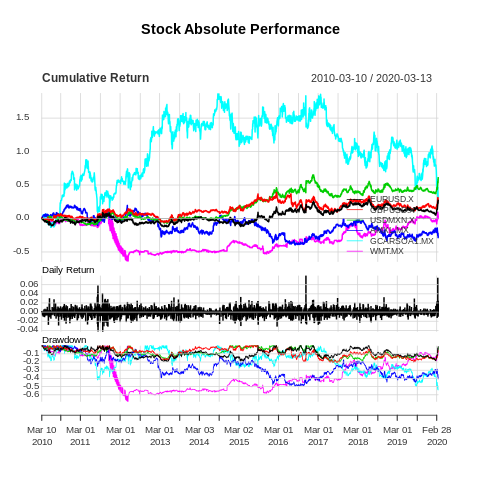

In [22]:
%%R
charts.PerformanceSummary(stock_returns,main='Stock Absolute Performance',legend.loc="bottomright")

In [31]:
%%R
n=nrow(DeltaX)
n
m=ncol(DeltaX)
m


V0=x0*pos #Valor del portafolio
#print(V0)
VT=sum(V0)
#print(sum(V0))
#Cálculo de Distribución de Pérdidas y Ganancias
X_ast<-matrix(0,n,m) #matriz de simulacion de precios
Y_ast<-matrix(0,n,m) #matriz de simulacion de instrumentos financieros
PL<-matrix(0,n,m) 
PLTdCAcc<-matrix(0,n,2) #POR FACTOR DE RIESGO
PLT=matrix(0,n,1) #TOTAL
for (i in (1:n))
{
  X_ast[i,]=x0*exp(DeltaX[i,]) #Simulación del precio
  Y_ast[i,]=X_ast[i,]*pos
  PL[i,]=Y_ast[i,]-V0  #Pérdidas y ganancias por posición
  PLTdCAcc[i,]=c(sum(PL[i,1:(len(pos_fx))]),sum(PL[i,(len(pos_fx)+1):(len(pos_eq)+len(pos_fx))])) #Pérdidas y ganancias por factor de riesgo
  PLT[i]=sum(PL[i,]) #Pérdidas y ganancias totales
}
#print(PL[1:10,])
#print(PLTdCAcc[1:10,])
#print(PLT[1:10,])
#print(PLT[1:10,])


 [1] -32484.8345   -384.9502    326.7009 108887.7993   -509.1067   -475.5825
 [7] -32257.3379    861.8084   8821.4702   -326.2727


##**VaR por posición sin alisado.**

In [56]:
%%R
#VaR por posición sin alisado
VaRCont=matrix(0,1,m)
CVaRCont=matrix(0,1,m)
alpha=0.95


for (i in (1:m))
{
VaRCont[i]=quantile(PL[,i],1-alpha,n)
CVaRCont[i]= mean(PL[which(PL[,i]<VaRCont[i]),i])
}

#Resumen medidas de riesgo por posición
VaRCont=as.data.table(VaRCont)
CVaRCont=as.data.table(CVaRCont)

#valores absolutos con respecto al portafolio sin alisado
names(VaRCont)=names(x0)
names(CVaRCont)=names(x0)
#print('valores absolutos con respecto al portafolio sin alisado')
#print("VaR")
#print(VaRCont/abs(as.matrix(V0)))
#print('CVaR')
#print(CVaRCont/abs(as.matrix(V0)))


#medias de riesgo por factor de riesgo acciones y divisas

VaRfr=matrix(0,1,2)
CVaRfr=matrix(0,1,2)

for (i in (1:2))
{
  VaRfr[i]=quantile(PLTdCAcc[,i],1-alpha,n)
  CVaRfr[i]= mean(PLTdCAcc[which(PLTdCAcc[,i]<VaRfr[i]),i])
}



VaRfr=as.data.table(VaRfr)
CVaRfr=as.data.table(CVaRfr)
#print('')
#print('medias de riesgo por factor de riesgo acciones y divisas')
#print(VaRfr)
#print(CVaRfr)

names(VaRfr)=c("divisas", "acciones")
names(CVaRfr)=c("divisas", "acciones")
#VALORES ABSOLUTOS
VaRfr/c(abs(as.matrix(sum(V0[,1:(len(pos_fx)+1)]))),abs(as.matrix(sum(V0[,(len(pos_fx)+1):(len(pos_eq)+len(pos_fx))]))))
CVaRfr/c(abs(as.matrix(sum(V0[,1:(len(pos_fx)+1)]))),abs(as.matrix(sum(V0[,(len(pos_fx)+1):(len(pos_eq)+len(pos_fx))]))))


#hist(as.matrix(PL[,3]))
#hist(as.matrix(PL[,2]))


#VaR Total
VaRTotal=quantile(PLT,1-alpha,n)
CVaRTotal= mean(PLT[which(PLT<VaRTotal),])

#VALOR ABSOLUTOS
print('VaR Total')
print(VaRTotal)
print(VaRTotal/sum(V0))
print('CVaR Total')
print(CVaRTotal)
print(CVaRTotal/sum(V0))

[1] "VaR Total"
       5% 
-61436.49 
        5% 
-0.0214372 
[1] "CVaR Total"
[1] -178578.1
[1] -0.06231173


##**VaR por posición con alisado**

In [0]:
%%R
#Medidas de riesgo CON alisado

#Se necesita definir
#1) El valor del peso inicial del primer escenario "w0"
#2) La función de cuantil con vector de probabilidades no iguales
#3) La función de CVaR con probabilidades no iguales

#w0=0.05

#Creación de dos funciones que sirven para este fin
# Percentil con pesos de probabilidades
# 
# v  un vector de observaciones
# w Un vector numérico de valores positivos, en general es la distrubición.
# p  el valor de la probabilidad entre 0 y 1.
# 
# Esta función no interpola

w0<-0.05

wquantile <- function(v,w=rep(1,length(v)),p=.5) 
{ 
  if ( !is.numeric(w) || length(v) != length(w) ) 
    stop("Los valores y los pesos tienen que tener misma longitud") 
  if ( !is.numeric(p) || any( p<0 | p>1) ) 
    stop("Percentil tiene que ser 0<=p<=1") 
  if ( min(w) < 0 ) stop("Los pesos tiene que ser mayores que 0") 
  ranking <- order(v) 
  sumw <- cumsum(w[ranking]) 
  plist <- sumw / sumw[ length(sumw) ] 
  v [ ranking [ which.max( plist >= p ) ] ]  
} 

#CVaR con alisado
wcvar <- function(v,w=rep(1,length(v)),p=.5) 
{ 
  if ( !is.numeric(w) || length(v) != length(w) ) 
    stop("Los valores y los pesos tienen que tener misma longitud") 
  if ( !is.numeric(p) || any( p<0 | p>1) ) 
    stop("Percentil tiene que ser 0<=p<=1") 
  if ( min(w) < 0 ) stop("Los pesos tiene que ser mayores que 0") 
  ranking <- order(v) 
  sumw <- cumsum(w[ranking]) 
  plist <- sumw / sumw[ length(sumw) ] 
  loss= v [ ranking [ which( plist < p ) ] ]  
  esc=w [ ranking [ which( plist < p ) ] ]  
  sum(loss*esc)/(sum(esc))
} 


#esc_cvar=which(cumsum(p_esc[order(PLT[,1])])<pdca)


#p_esc[esc_cvar]

#tshs=cbind(PLT,p_esc)


In [64]:
%%R
lambda =uniroot(function(x) w0*(1-x^(n))/(1-x)-1, c(0,0.99), tol = 1e-28)$root
lambda

#generamos la función que genera "n" escenarios con base en w0 y lambda
genera_esc=function(lamda,w0,n)
{
  p_esc=matrix(0,n,1)
  for (i in (1:n))
  {
    p_esc[i]=w0*lambda^(i-1)
  }
  p_esc
}

p_esc=genera_esc(lambda,w0,n)
t(p_esc[1:10])
sum(p_esc) #validamos que sume 1

#Creamos las cajas de VaR y CVaR con alisado
VaRca=matrix(0,1,ncol(PL))
CVaRca=matrix(0,1,ncol(PL))

#IMPORTANTE: VALIDAR QUE SE TENGA EL MISMO ORDEN DE ESCENARIOS, ES POR ESO QUE METEMOS P_ESC[ORDER(P_ESC)]
for (j in (1:m))
{
  VaRca[j]=wquantile(as.matrix(PL[,j]), p_esc[order(p_esc)], 1-alpha)
  CVaRca[j]=wcvar(as.matrix(PL[,j]), as.matrix(p_esc[order(p_esc)]), 1-alpha)
}

#Resumen medidas de riesgo por posición
VaRca=as.data.table(VaRca)
CVaRca=as.data.table(CVaRca)

#valores absolutos con respecto al portafolio sin alisado
names(VaRca)=names(x0)
names(CVaRca)=names(x0)
VaRca/abs(as.matrix(V0))
CVaRca/abs(as.matrix(V0))


#medias de riesgo por factor de riesgo acciones y divisas

VaRfrca=matrix(0,1,2)
CVaRfrca=matrix(0,1,2)


for (j in (1:2))
{
  VaRfrca[j]=wquantile(as.matrix(PLTdCAcc[,j]), p_esc[order(p_esc)], 1-alpha)
  CVaRfrca[j]= wcvar(as.matrix(PLTdCAcc[,j]), as.matrix(p_esc[order(p_esc)]), 1-alpha)
}



VaRfrca=as.data.table(VaRfrca)
CVaRfrca=as.data.table(CVaRfrca)

names(VaRfrca)=c("divisas", "acciones")
names(CVaRfrca)=c("divisas", "acciones")
#VALORES ABSOLUTOS
VaRfrca/c(abs(as.matrix(sum(V0[,1:(len(pos_fx)+1)]))),abs(as.matrix(sum(V0[,(len(pos_fx)+1):(len(pos_eq)+len(pos_fx))]))))
CVaRfrca/c(abs(as.matrix(sum(V0[,1:(len(pos_fx)+1)]))),abs(as.matrix(sum(V0[,(len(pos_fx)+1):(len(pos_eq)+len(pos_fx))]))))


VaRcaT=wquantile(as.matrix(PLT), p_esc[order(p_esc)], 1-alpha)
CVaRcaT=wcvar(as.matrix(PLT), p_esc[order(p_esc)], 1-alpha)


V0
VaRCont/abs(as.matrix(V0))
VaRca/abs(as.matrix(V0))
CVaRCont/abs(as.matrix(V0))
CVaRca/abs(as.matrix(V0))


c(sum(V0[,1:3]),sum(V0[,4:5]))
VaRfr/c(abs(as.matrix(sum(V0[,1:3]))),abs(as.matrix(sum(V0[,4:5]))))
VaRfrca/c(abs(as.matrix(sum(V0[,1:3]))),abs(as.matrix(sum(V0[,4:5]))))
CVaRfr/c(abs(as.matrix(sum(V0[,1:3]))),abs(as.matrix(sum(V0[,4:5]))))
CVaRfrca/c(abs(as.matrix(sum(V0[,1:3]))),abs(as.matrix(sum(V0[,4:5]))))


sum(V0)
print('VaR')
print(VaRTotal/abs(sum(V0)))
print(VaRcaT/abs(sum(V0)))
print('CVaR')
print(CVaRTotal/abs(sum(V0)))
print(CVaRcaT/abs(sum(V0)))


[1] "VaR"
        5% 
-0.0214372 
[1] -0.03586113
[1] "CVaR"
[1] -0.06231173
[1] -0.06190322
